In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
class MultiClassNetwork:
  def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
    self.units = units
    self.batch_size = batch_size
    self.w1 = None
    self.b1 = None
    self.w2 = None
    self.b2 = None
    self.a1 = None
    self.losses = []
    self.val_losses = []
    self.lr = learning_rate
    self.l1 =l1
    self.l2 = l2
    
  def forpass(self, x):
    z1 = np.dot(x, self.w1) + self.b1
    self.a1 = self.sigmoid(z1)
    z2 = np.dot(self.a1, self.w2) + self.b2
    return z2

  def backprop(self, x, err):
    m = len(x)
    w2_grad = np.dot(self.a1.T, err)/ m
    b2_grad = np.sum(err) / m
    err_to_hidden = np.dot(err, self.w2.T)*self.a1*(1-self.a1)
    w1_grad = np.dot(x.T, err_to_hidden)/m
    b1_grad = np.sum(err_to_hidden, axis=0) /m
    return w1_grad, b1_grad, w2_grad, b2_grad

  def sigmoid(self,z):
    a= 1/(1+np.exp(-z))
    return a

  def softmax(self,z):
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1).reshape(-1,1)

  def init_weights(self, n_features, n_classes):
    self.w1 = np.random.normal(0,1, (n_features, self.units))
    self.b1 = np.zeros(self.units)
    self.w2 = np.random.normal(0,1, (self.units, n_classes))
    self.b2 = np.zeros(n_classes)

  def fit(self, x, y, epochs=100, x_val = None, y_val =None):
    np.random.seed(42)
    self.init_weights(x.shape[1], y.shape[1])
    for i in range(epochs):
      loss=0
      print('.', end='')
      for x_batch, y_batch in self.gen_batch(x,y):
        a = self.training(x_batch, y_batch)
        a = np.clip(a, 1e-10, 1-1e-10)
        loss += np.sum(-y_batch*np.log(a))
      self.losses.append((loss + self.reg_loss()) / len(x))
      self.update_val_loss(x_val, y_val)

  def gen_batch(self, x, y):
    length = len(x)
    bins = length // self.batch_size
    if length % self.batch_size:
      bins +=1
    indexes = np.random.permutation(np.arange(len(x)))
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i + 1)
      yield x[start:end], y[start:end]
  
  def training(self, x, y):
    m = len(x)
    z= self.forpass(x)
    a = self.softmax(z)
    err = -(y-a)
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
    
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad
    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad
    return a

  def predict(self, x):
    z = self.forpass(x)
    return np.argmax(z, axis=1)

  def score(self, x, y):
    return np.mean(self.predict(x) == np.argmax(y, axis=1))
  
  def reg_loss(self):
    return self.l1*(np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + self.l2/2*(np.sum(self.w1**2) +np.sum(self.w2**2))

  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)
    a = self.softmax(z)
    a = np.clip(a, 1e-10, 1-1e-10)
    val_loss = np.sum(-y_val*np.log(a))
    self.val_losses.append((val_loss + self.reg_loss())/ len(y_val))


In [3]:
!pip install tensorflow_gpu==2.0.0-rc2

     |████████████████████████████████| 380.8MB 44kB/s 
     |████████████████████████████████| 3.8MB 56.3MB/s 
     |████████████████████████████████| 501kB 48.0MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


In [0]:
import tensorflow as tf

In [10]:
tf.__version__

'1.15.0'

In [11]:
(x_train_all, y_train_all),(x_test, y_test) =tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [5]:
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


<function matplotlib.pyplot.show>

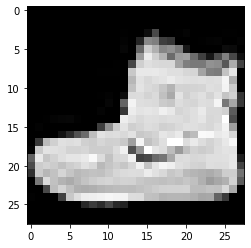

In [6]:
plt.imshow(x_train_all[0], cmap='gray')
plt.show

In [7]:
print(y_train_all[:10])

[9 0 0 3 0 2 7 2 5 5]


In [8]:
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [10]:
print(np.bincount(y_train))
print(np.bincount(y_val))

[4800 4800 4800 4800 4800 4800 4800 4800 4800 4800]
[1200 1200 1200 1200 1200 1200 1200 1200 1200 1200]


In [0]:
#normalization
x_train = x_train/255
x_val = x_val/255

In [0]:
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1,784)

In [13]:
print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


In [15]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)
print( y_train_encoded.shape, y_val_encoded.shape)

(48000, 10) (12000, 10)


In [16]:
fc = MultiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=40)

........................................

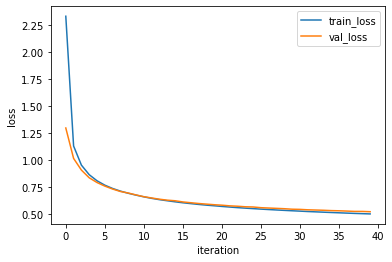

In [17]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [18]:
fc.score(x_val, y_val_encoded)

0.8150833333333334

### **7-2 KERAS**

In [0]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()

In [0]:
model.add(Dense(100, activation='sigmoid', input_shape=(784,)))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
history=model.fit(x_train, y_train_encoded, epochs=40, validation_data=(x_val, y_val_encoded))

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 5s 110us/sample - loss: 1.3775 - acc: 0.6551 - val_loss: 0.9676 - val_acc: 0.7367
Epoch 2/40
48000/48000 [==============================] - 4s 78us/sample - loss: 0.8481 - acc: 0.7429 - val_loss: 0.7553 - val_acc: 0.7593
Epoch 3/40
48000/48000 [==============================] - 4s 78us/sample - loss: 0.7130 - acc: 0.7641 - val_loss: 0.6647 - val_acc: 0.7779
Epoch 4/40
48000/48000 [==============================] - 4s 78us/sample - loss: 0.6462 - acc: 0.7814 - val_loss: 0.6114 - val_acc: 0.7937
Epoch 5/40
48000/48000 [==============================] - 4s 78us/sample - loss: 0.6037 - acc: 0.7940 - val_loss: 0.5760 - val_acc: 0.8041
Epoch 6/40
48000/48000 [==============================] - 4s 80us/sample - loss: 0.5734 - acc: 0.8037 - val_loss: 0.5494 - val_acc: 0.8103
Epoch 7/40
48000/48000 [==============================] - 4s 78us/sample - loss: 0.5507 - acc: 0.8110 - val_loss: 0

In [19]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


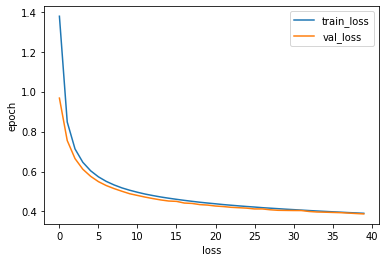

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('loss')
plt.ylabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

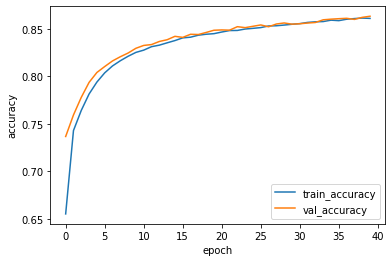

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [27]:
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)
print(accuracy)

0.86333334
